In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from scipy.stats import invgauss
from itertools import product
import xarray 
import warnings
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')

np.random.seed(250197)
def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(**params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def sharpSample(func,params,rate):
    searching = True
    time = 0
    nextRate = round(1/rate)
    while searching:
        nextPassage = func(**params)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def pade3_2(x,U0,U1,D1,U2,D2,D3):
    return (U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+1)

def pade2_2(x,U0,U1,D1,U2,D2):
    return (U2*x**2+x*U1+U0)/(D2*x**2+x*D1+1)

def pade3_3(x,U0,U1,D1,U2,D2,U3,D3):
    return (U3*x**3+U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+1)

def pade3_4(x,A,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def IGLaplace(rs,L,D,V):
    return np.exp(L/(2*D)*(V-np.sqrt(V**2+4*D*rs)))

def forwardExpansion(x,x0,delta,vals):

    first = (-49/20*vals[0] + 6*vals[1] -15/2*vals[2] + 20/3*vals[3] -15/4*vals[4] + 6/5*vals[5] -1/6*vals[6])/delta
    second = (469/90*vals[0] -223/10*vals[1] +879/20*vals[2] -949/18*vals[3] +41*vals[4] -201/10*vals[5] +1019/180*vals[6]-7/10*vals[7])/(delta**2)
    third = (-801/80*vals[0] +349/6*vals[1] -18353/120*vals[2] +2391/10*vals[3] -1457/6*vals[4] +4891/30*vals[5] -561/8*vals[6]+527/30*vals[7]-469/240*vals[8])/(delta**3)
    fourth = (1069/80*vals[0] -1316/15*vals[1] +15289/60*vals[2] -2144/5*vals[3] +10993/24*vals[4] -4772/15*vals[5] +2803/20*vals[6]-536/15*vals[7]+967/240 *vals[8])/(delta**4)
    
    return vals[0] + first*(x-x0) + second*(x-x0)**2/2 + third*(x-x0)**3/6 + fourth*(x-x0)**4/24

def GammaLaplace(rs,k,theta):
    return (1+rs*theta)**(-k)

def FrechetLaplace(rs,**kwargs):
    return 2*np.sqrt(rs)*scp.special.kn(1,2*np.sqrt(rs))
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
# plt.style.use('default')
plt.style.use('seaborn-colorblind')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rc("savefig", dpi=300)

Plot predictions...

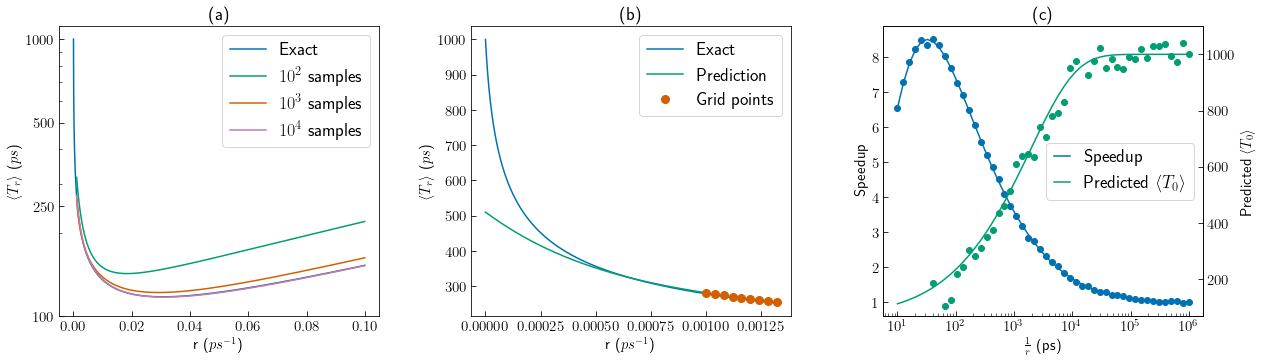

In [105]:
# Set parameters
mu = 1000000
CV = 5
D = 0.5*mu*CV**2
m = 2*D/mu
s = mu/m

# plot exact mean FPT vs r
fig, axs = plt.subplots(1,3,figsize=(18,6))            
fig.tight_layout(pad=4.0)
rs = np.linspace(0.000000,0.0001,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = mu
axs[0].plot(rs*1000,mus/1000,label="Exact")

# plot predicted mean FPT vs r
rate = 0.000001
rs = np.linspace(rate,0.0001,1000)
for size,name in zip([100,1000,10000],[r"$10^2$",r"$10^3$",r"$10^4$"]):
    samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(size)])
    Trs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (rs-rate)])
    mus = (1-Trs)/((rs-rate)*Trs)
    axs[0].plot(rs*1000,mus/1000,label=f"{name} samples")
    
# Arrange plot a
axs[0].legend()
axs[0].set_xlabel(r"r ($ps^{-1}$)")
axs[0].set_ylabel(r"$\langle T_r \rangle$ ($ps$)")
axs[0].set_yscale("log")
axs[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_yticks([100,250,500,1000])
axs[0].set_title("(a)")

# plot exact mean FPT vs r
dr = 25
rs = np.linspace(0,rate+8*rate/dr,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
axs[1].plot(rs*1000,mus/1000,label="Exact")

# plot predicted mean FPT vs r
selrs = np.linspace(rate,rate+8*rate/dr,9)
selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
selmus = (1-selTrs)/((selrs-rate)*selTrs)
selmus[0] = samples.mean()
pres = forwardExpansion(rs,rate,rate/dr,selmus)
axs[1].plot(rs*1000,pres/1000,label="Prediction")
axs[1].plot(selrs*1000,selmus/1000,"o",label="Grid points",markersize=8)

# Arrange plot b
axs[1].set_xlabel(r"r ($ps^{-1}$)")
axs[1].set_ylabel(r"$\langle T_r \rangle$ ($ps$)")
axs[1].legend()
axs[1].set_title("(b)")
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# plot speed up
oneOverRs = np.logspace(np.log10(10000),np.log10(1000000000),50)
rs = 1/oneOverRs
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
lns1 = axs[2].plot(0.001*oneOverRs,mu/mus,label="Speedup")

# First prediction
predictions = []
for rate in rs:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = IGLaplace(selrs,mu,D,1)
    selmus = (1-selTrs)/(selrs*selTrs)
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
predictions = np.array(predictions)
ax12 = axs[2].twinx()
ax12.plot(100,300)
ax12.scatter(100,-300)
lns2 = ax12.plot(0.001*oneOverRs,predictions/1000,label=r"Predicted $\langle T_0 \rangle$")

# plot simulated
mus = []
pres = []
for rate in rs:
    samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(20000)])
    mus.append(samples.mean())
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = samples.mean()
    pres.append(forwardExpansion(0,rate,rate/dr,selmus))

mus = np.array(mus)
pres = np.array(pres)
axs[2].scatter(0.001*oneOverRs,mu/mus)
ax12.scatter(0.001*oneOverRs,pres/1000)

# View
ax12.set_ylim(68.4921390575665, 1100)
axs[2].set_ylabel("Speedup")
ax12.set_ylabel(r"Predicted $\langle T_0 \rangle$")
axs[2].set_xlabel(r"$\frac{1}{r}$ (ps)")
axs[2].set_xscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[2].legend(lns,labs,loc="center right",handlelength=0.9)
axs[2].set_title("(c)")
plt.savefig("analyticPredictionAndExtrapolation.png")

In [40]:
mu/mus

['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

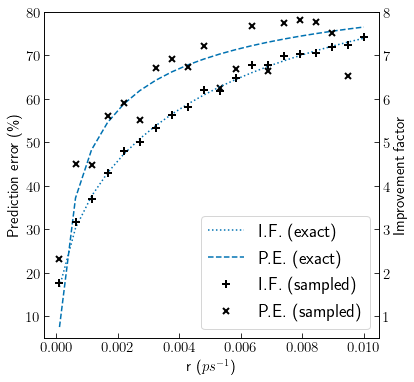

In [3]:
# plot analytical improvement vs r
rs = np.linspace(0.0000001,0.00001,20)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax2 = ax.twinx()
lns1 = ax2.plot(rs*1000,mu/mus,linestyle="dotted",label="I.F. (exact)")
ax2.set_ylim(0.5,8)
ax2.set_ylabel("Improvement factor")

# plot analytical error vs r
predictions = []
for rate in rs:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = IGLaplace(selrs,mu,D,1)
    selmus = (1-selTrs)/(selrs*selTrs)
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
predictions = np.array(predictions)
errors = 100*abs(mu-predictions)/mu
lns2 = ax.plot(rs*1000,errors,linestyle="dashed",label="P.E. (exact)")

# plot simulated
improvements = []
errors = []
for rate in rs:
    samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(10000)])
    improvements.append(mu/samples.mean())
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = samples.mean()
    pres = forwardExpansion(0,rate,rate/dr,selmus)
    errors.append(100*abs(mu-pres)/mu)
lns3 = ax2.plot(rs*1000,improvements,"+",label="I.F. (sampled)",c="black",mew=2,ms=8)
lns4 = ax.plot(rs*1000,errors,"x",label="P.E. (sampled)",c="black",mew=2)

# Arrange plot
ax.set_ylim(5,80)
ax.set_ylabel("Prediction error (\%)")
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc="lower right")
ax.set_xlabel(r"r ($ps^{-1}$)")
# plt.savefig("tradeoff.png")

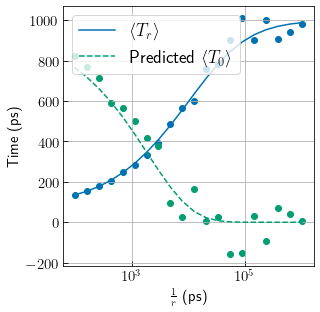

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
fig.tight_layout(pad=5.0)
# Mean Tr
oneOverRs = np.logspace(np.log10(100000),np.log10(1000000000),20)
rs = 1/oneOverRs
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
ax.plot(0.001*oneOverRs,mus/1000,label=r"$\langle T_r \rangle$")

# First prediction
predictions = []
for rate in rs:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = IGLaplace(selrs,mu,D,1)
    selmus = (1-selTrs)/(selrs*selTrs)
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
predictions = np.array(predictions)
ax.plot(0.001*oneOverRs,1000-predictions/1000,linestyle="dashed",label=r"Predicted $\langle T_0 \rangle$")

# Second prediction

# pre2 = []
# oneOverRs2 = []
# for i in range(len(predictions)-6):
#     try:
#         fit = scp.optimize.curve_fit(pade2_2,0.001*oneOverRs[i:i+6],predictions[i:i+6]/1000 ,bounds=(0,np.inf))
#         pre2.append(pade2_2(1e10,*fit[0]))
#         oneOverRs2.append(0.001*oneOverRs[i+6])
#     except:
#         pass
# ax.plot(oneOverRs2,pre2,linestyle="dotted",label=r"Predicted $\langle T_0 \rangle$")

# plot simulated
mus = []
pres = []
for rate in rs:
    samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(10000)])
    mus.append(samples.mean())
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = samples.mean()
    pres.append(forwardExpansion(0,rate,rate/dr,selmus))

mus = np.array(mus)
pres = np.array(pres)
ax.scatter(0.001*oneOverRs,mus/1000)
ax.scatter(0.001*oneOverRs,1000-pres/1000)


# View

ax.legend()
ax.grid()
ax.set_ylabel("Time (ps)")
ax.set_xlabel(r"$\frac{1}{r}$ (ps)")
ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_ylim(100,1100)

(array([-1.41116159e+09,  6.59144102e+04,  2.82560649e-01,  1.91521042e-01,
         1.89116653e-07]),
 array([[ 4.63543568e+27, -2.16489821e+23, -9.28055063e+17,
         -6.29042935e+17, -6.21145843e+11],
        [-2.16489821e+23,  1.01107740e+19,  4.33431695e+13,
          2.93783372e+13,  2.90095175e+07],
        [-9.28055063e+17,  4.33431695e+13,  1.85804800e+08,
          1.25939938e+08,  1.24358870e+02],
        [-6.29042935e+17,  2.93783372e+13,  1.25939938e+08,
          8.53630686e+07,  8.42914089e+01],
        [-6.21145843e+11,  2.90095175e+07,  1.24358870e+02,
          8.42914089e+01,  8.32332028e-05]]))

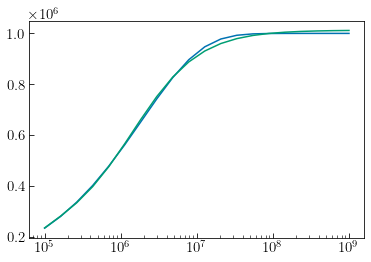

In [209]:
predictions = []
pre2 = []
mus = []
oneOverRs = np.logspace(np.log10(100000),np.log10(1000000000),20)
originalRates = 1/oneOverRs
for rate in originalRates:
    Trs = IGLaplace(rate,mu,D,1)
    mus.append((1-Trs)/(rate*Trs))
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    selTrs = IGLaplace(selrs,mu,D,1)
    selmus = (1-selTrs)/(selrs*selTrs)
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
    # specificPredictions = [predictions[-1]]
    # rates = [rate]
    # for i in range(2,7):
    #     r = rate*i
    #     rates.append(r)
    #     selrs = np.linspace(r,r+8*rate/dr,9)
    #     selTrs = IGLaplace(selrs,mu,D,1)
    #     selmus = (1-selTrs)/(selrs*selTrs)
    #     specificPredictions.append(forwardExpansion(0,r,rate/dr,selmus))
    # fit = scp.optimize.curve_fit(pade2_2,rates,specificPredictions ,bounds=(0,np.inf))
    # pre2.append(pade2_2(0,*fit[0]))

# plt.plot(oneOverRs,mus)
plt.plot(oneOverRs,predictions)

def func(x,M,alpha,beta):
    return M*(1-np.exp(-alpha*x-beta*x**2))

fit = scp.optimize.curve_fit(pade2_2,oneOverRs,predictions)           
plt.plot(oneOverRs,pade2_2(oneOverRs,*fit[0]))
# plt.plot(oneOverRs,pre2)
plt.xscale("log")
fit
# mus = []
# pres = []
# pre2 = []
# for rate in originalRates:
#     samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(10000)])
#     mus.append(samples.mean())
#     selrs = np.linspace(rate,rate+8*rate/dr,9)
#     selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
#     selmus = (1-selTrs)/((selrs-rate)*selTrs)
#     selmus[0] = samples.mean()
#     pres.append(forwardExpansion(0,rate,rate/dr,selmus))
#     specificPredictions = [predictions[-1]]
#     rates = [rate]
#     for i in range(2,7):
#         newR = rate*i
#         rates.append(newR)
#         selrs = np.linspace(newR,newR+8*rate/dr,9)
#         selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
#         selmus = (1-selTrs)/((selrs-rate)*selTrs)
#         specificPredictions.append(forwardExpansion(0,newR,rate/dr,selmus))
#     fit = scp.optimize.curve_fit(pade2_2,rates,specificPredictions ,bounds=(0,np.inf))
#     pre2.append(pade2_2(0,*fit[0]))

# mus = np.array(mus)
# pres = np.array(pres)
# plt.scatter(oneOverRs,mus)
# plt.scatter(oneOverRs,pres)
# plt.scatter(oneOverRs,pre2)
# plt.ylim(0,1500000)

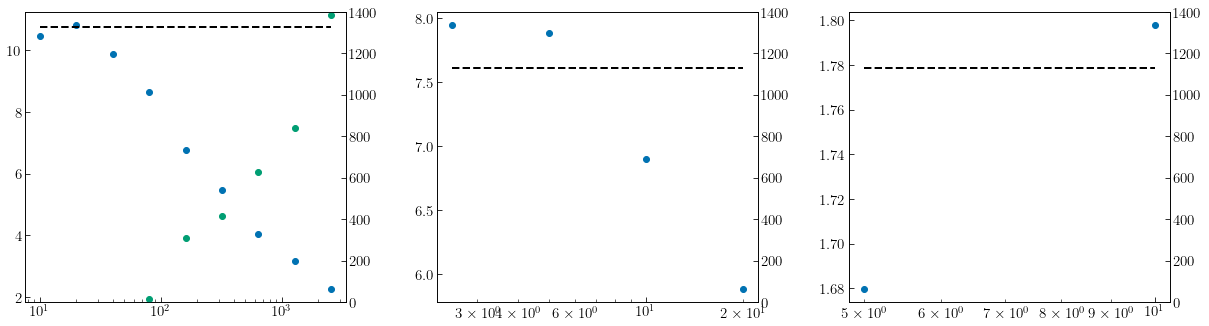

In [17]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
fig.tight_layout(pad=4.0)
dr = 25
predictions = []
mus = []
rates =[0.0001,0.00005,0.000025,0.0000125,0.00000625,0.000003125,0.0000015625,0.00000078125,0.000000390625]
for rate in rates:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    fpts = np.loadtxt(f"results/FPT1Drate{str(rate*1000).split('.')[-1]}",skiprows=1)
    selTrs = np.array([sum(np.exp(-r*fpts))/len(fpts) for r in selrs-rate])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = fpts.mean()
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
    mus.append(fpts.mean())
predictions = np.array(predictions)
mus = np.array(mus)
unbiased = np.loadtxt("results/FPT1Drate0",skiprows=1).mean()
axs[0].plot(0.001/np.array(rates),unbiased/mus,"o")
ax02 = axs[0].twinx()
ax02.plot(0.001/np.array(rates),predictions/1000,"o",label=r"Predicted $\langle T_0 \rangle$",c="#009E73")
ax02.plot(0.001/np.array(rates),[unbiased/1000 for r in rates],c="black",linestyle="dashed",linewidth=2)
ax02.set_ylim(0,1400)
ax02.set_xscale("log")

predictions = []
mus = []
rates =[0.0004,0.0002,0.0001,0.00005]
for rate in rates:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    fpts = np.loadtxt(f"results/FPT2Grate{str(rate*1000).split('.')[-1]}",skiprows=1)
    selTrs = np.array([sum(np.exp(-r*fpts))/len(fpts) for r in selrs-rate])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = fpts.mean()
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
    mus.append(fpts.mean())
predictions = np.array(predictions)
mus = np.array(mus)
unbiased = np.loadtxt("results/FPT2Grate0",skiprows=1).mean()
axs[1].plot(0.001/np.array(rates),unbiased/mus,"o")
ax12 = axs[1].twinx()
ax12.plot(0.001/np.array(rates),predictions/1000,"o",label=r"Predicted $\langle T_0 \rangle$",c="#009E73")
ax12.plot(0.001/np.array(rates),[unbiased/1000 for r in rates],c="black",linestyle="dashed",linewidth=2)
ax12.set_ylim(0,1400)
ax12.set_xscale("log")

predictions = []
mus = []
rates =[0.0002,0.0001]
for rate in rates:
    selrs = np.linspace(rate,rate+8*rate/dr,9)
    fpts = np.loadtxt(f"results/FPTWQrate{str(rate*1000).split('.')[-1]}",skiprows=1)
    selTrs = np.array([sum(np.exp(-r*fpts))/len(fpts) for r in selrs-rate])
    selmus = (1-selTrs)/((selrs-rate)*selTrs)
    selmus[0] = fpts.mean()
    predictions.append(forwardExpansion(0,rate,rate/dr,selmus))
    mus.append(fpts.mean())
predictions = np.array(predictions)
mus = np.array(mus)
unbiased = np.loadtxt("results/FPTWQrate0",skiprows=1).mean()
axs[2].plot(0.001/np.array(rates),unbiased/mus,"o")
ax22 = axs[2].twinx()
ax22.plot(0.001/np.array(rates),predictions/1000,"o",label=r"Predicted $\langle T_0 \rangle$",c="#009E73")
ax22.plot(0.001/np.array(rates),[unbiased/1000 for r in rates],c="black",linestyle="dashed",linewidth=2)
ax22.set_ylim(0,1400)
ax22.set_xscale("log")
# predictions

In [16]:
mus
# plot 1D mean fpt and improvement against r
# ax12 = axs[0][2].twinx()
# # axs[0][2].scatter(rates,fpts/1000,c="black")
# axs[0][2].scatter(1/np.array(rates[1:]),cfpts/1000,c="black")
# # ax12.scatter(rates,fpts[0]/fpts,marker="+",c="black")
# ax12.scatter(1/np.array(rates[1:]),fpts[0]/cfpts,marker="+",c="black")
# ax12.set_ylabel("Speedup (+)")
# axs[0][2].set_ylabel(r"$\langle T_r \rangle$ ($ps$) ($\bullet$)")
# axs[0][2].set_xlabel(r"r ($ps^{-1}$)")
# axs[0][2].set_xscale("log")
# ax12.set_ylim(0,13)

array([1129593.9, 1129593.9])

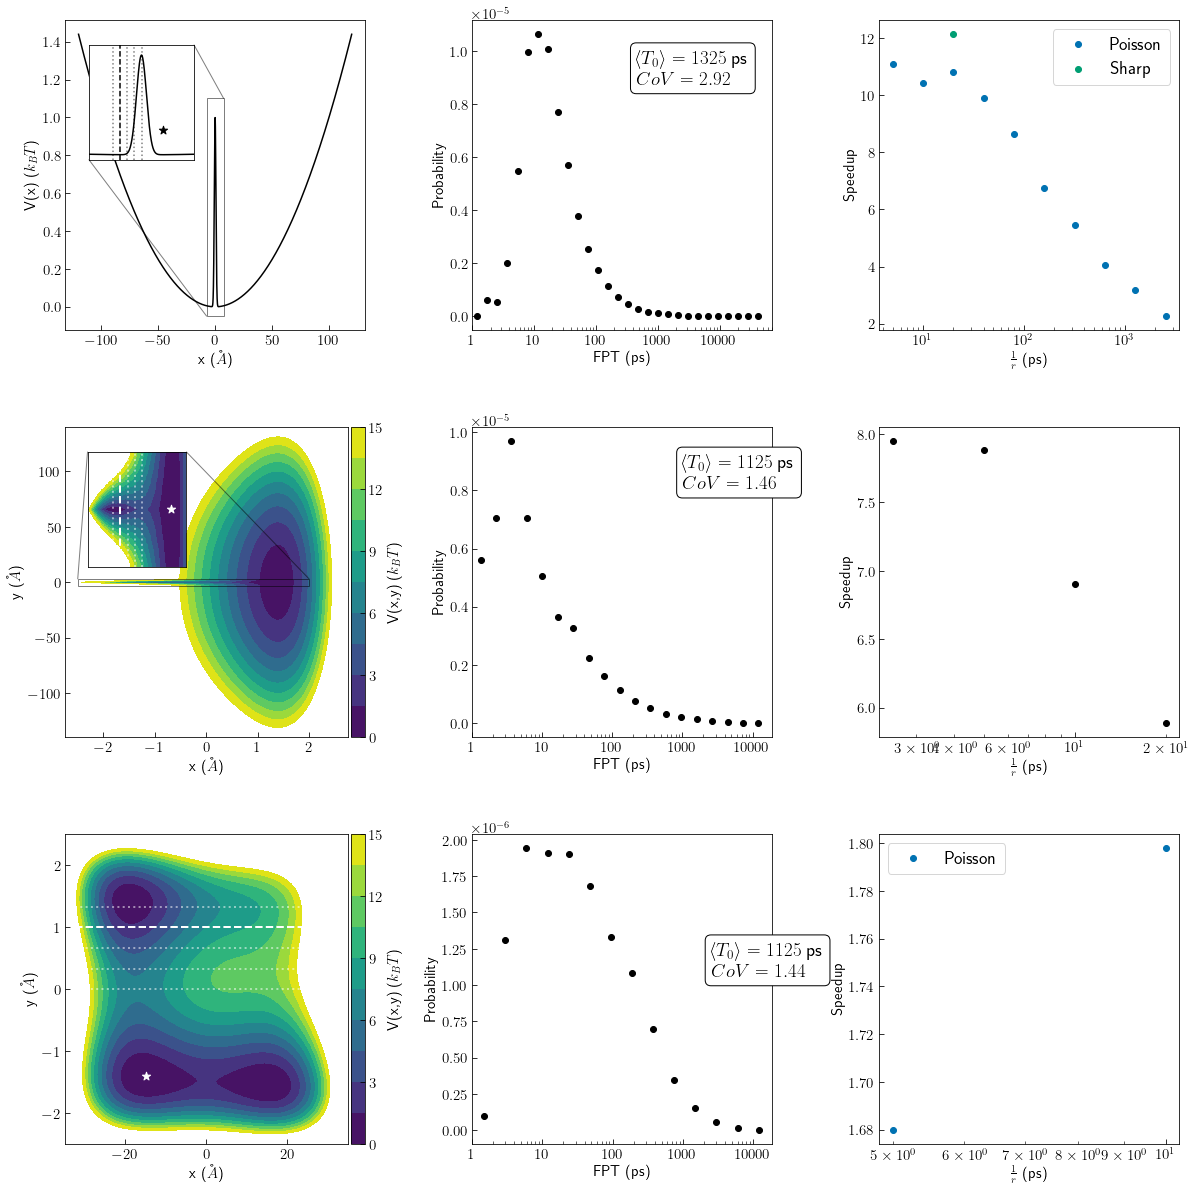

In [4]:
# plot 1D potential
fig, axs = plt.subplots(3,3,figsize=(18,18))
fig.tight_layout(pad=5.0)
A = 0.59616/10000
B = 0.59616
C = 1
x = np.linspace(-120,120,10000)
V = A*x**2 + B*np.exp(-C*x**2)
axs[0][0].plot(x,(V-V.min())/0.59616,c="black",label="Potential")
axs[0][0].set_xlabel(r"x ($\AA$)")
axs[0][0].set_ylabel(r"V(x) ($k_BT$)")

axins = axs[0][0].inset_axes([0.08, 0.55, 0.35, 0.37])
axins.plot(x,(V-V.min())/0.59616,c="black")
axins.plot([-3,-3],[-0.05, 1.2],linestyle="dashed",c="black")
for x in [0,-1,-2,-4]:
    axins.plot([x,x],[-0.05, 1.2],linestyle="dotted",c="black",alpha=0.5)
axins.scatter(3,0.25,marker="*",c="black",s=75)
axins.set_xlim(-7.5, 7.5)
axins.set_ylim(-0.05, 1.1)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 
axs[0][0].indicate_inset_zoom(axins, edgecolor="black")

# make 1D fpt array
rates =[0.2,0.1,0.05,0.025,0.0125,0.00625,0.003125,0.0015625,0.00078125,0.000390625]
fpts = []
cfpts = []
for rate in rates:
    fpts.append(np.loadtxt(f"results/FPT1Drate{str(rate).split('.')[-1]}",skiprows=1).mean())
    try:
        cfpts.append(np.loadtxt(f"results/cFPT1Drate{str(rate).split('.')[-1]}",skiprows=1).mean())
    except:
        pass
fpts = np.array(fpts)
cfpts = np.array(cfpts)
unbiased = np.loadtxt(f"results/FPT1Drate0",skiprows=1)

# plot selected rates
logbins = np.logspace(np.log10(unbiased.min()-1000),np.log10(unbiased.max()),30)
xs = 0.5*(logbins[1:] + logbins[:-1])
c,b = np.histogram(unbiased, bins=logbins, density=True)
# for i in range(1,len(rates),3):
#     axs[0][1].plot([1/rates[i],1/rates[i]],[0,c.max()],linestyle="dashed")
#     axs[0][2].plot([1/rates[i],1/rates[i]],[fpts[0]/cfpts.min(),fpts[0]/cfpts.max()],linestyle="dashed")
    # axs[0][2].plot([1/rates[i],1/rates[i]],[fpts.min()/1000,fpts.max()/1000],linestyle="dashed")

# plot 1D fpt histogram
axs[0][1].plot(xs/1e3,c,"o",c="black")
axs[0][1].set_xscale("log")
axs[0][1].set_ylabel("Probability")
axs[0][1].set_xlabel("FPT (ps)")
axs[0][1].set_xlim(1)
axs[0][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0][1].set_xticks([1,10,100,1000,10000])

props = dict(boxstyle='round', facecolor='white')
axs[0][1].text(450,8.75e-6,fr"$\langle T_0 \rangle = {round(unbiased.mean()/25000)*25}$ ps" + "\n" +fr"$CoV = {format(unbiased.std()/unbiased.mean(),'.2f')}$",fontsize=19,bbox=props)

axs[0][2].scatter(1/np.array(rates),unbiased.mean()/fpts,label="Poisson")
axs[0][2].scatter(1/0.05,unbiased.mean()/cfpts,label="Sharp")
axs[0][2].set_ylabel("Speedup")
axs[0][2].set_xlabel(r"$\frac{1}{r}$ (ps)")
axs[0][2].set_xscale("log")
axs[0][2].legend()

# plot Wolfe Quapp potential
pointsx = np.linspace(-35,35,100)
pointsy = np.linspace(-2.5,2.5,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,15,11)
for xt in pointsx:
    x = xt/15
    for yt in pointsy:
        y = yt/1
        Vs.append(1.5*0.59616*(x**4+y**4-2*x**2-4*y**2+x*y+1.5*x+1.2*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
im = axs[2][0].tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axs[2][0].plot([-32.5,32.5],[1, 1],linestyle="dashed",linewidth=2,c="white")
for y in [0,1/3,2/3,4/3]:
    axs[2][0].plot([-32.5,32.5],[y,y],linestyle="dotted",linewidth=2,c="white",alpha=0.5)
axs[2][0].scatter(-14.9,-1.4,marker="*",c="white",s=75)
divider = make_axes_locatable(axs[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[2][0].set_xlabel(r"x ($\AA$)")
axs[2][0].set_ylabel(r"y ($\AA$)")

rates =[0.2,0.1]
fpts = []
cfpts = []
for rate in rates:
    fpts.append(np.loadtxt(f"results/FPTWQrate{str(rate).split('.')[-1]}",skiprows=1).mean())
    try:
        cfpts.append(np.loadtxt(f"results/cFPTWQrate{str(rate).split('.')[-1]}",skiprows=1).mean())
    except:
        pass
fpts = np.array(fpts)
cfpts = np.array(cfpts)
unbiased = np.loadtxt(f"results/FPTWQrate0",skiprows=1)

# plot selected rates
logbins = np.logspace(np.log10(unbiased.min()),np.log10(unbiased.max()),15)
xs = 0.5*(logbins[1:] + logbins[:-1])
c,b = np.histogram(unbiased, bins=logbins, density=True)
# for i in range(1,len(rates),3):
#     axs[2][1].plot([1/rates[i],1/rates[i]],[0,c.max()],linestyle="dashed")
#     axs[2][2].plot([rates[i],rates[i]],[fpts.min()/1000,fpts.max()/1000],linestyle="dashed")

# plot Wolfe Quapp fpt histogram
axs[2][1].plot(xs/1e3,c,"o",c="black")
axs[2][1].set_xscale("log")
axs[2][1].set_ylabel("Probability")
axs[2][1].set_xlabel("FPT (ps)")
axs[2][1].set_xlim(1)
axs[2][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[2][1].set_xticks([1,10,100,1000,10000])
axs[2][1].text(2500,1.06e-6,fr"$\langle T_0 \rangle = {round(unbiased.mean()/25000)*25}$ ps" + "\n" +fr"$CoV = {format(unbiased.std()/unbiased.mean(),'.2f')}$",fontsize=19,bbox=props)

axs[2][2].scatter(1/np.array(rates),unbiased.mean()/fpts,label="Poisson")
# axs[2][2].scatter(1/0.05,unbiased.mean()/cfpts,label="Sharp")
axs[2][2].set_ylabel("Speedup")
axs[2][2].set_xlabel(r"$\frac{1}{r}$ (ps)")
axs[2][2].set_xscale("log")
axs[2][2].legend()

# plot Gaussians potential
pointsy = np.linspace(-140,140,99)
pointsx = np.linspace(-2.75,2.75,100)
xs = []
ys = []
Vs = []
A = [24.44,24.44]
alphas = [1.3,1.3]
lambdas = [2000,1]
x0s = [2.5,-2.5]
y0s = [0,0]
for x in pointsx:
    for y in pointsy:
        W_1 = A[0]*np.exp(-(x-x0s[0])**2/(2*alphas[0]**2)-(y-y0s[0])**2/(2*lambdas[0]**2))
        W_2 = A[1]*np.exp(-(x-x0s[1])**2/(2*alphas[1]**2)-(y-y0s[1])**2/(2*lambdas[1]**2))
        Vs.append((-(W_1 + W_2) + 4*x**2 + 0.0005*y**2))
        xs.append(x)
        ys.append(y)
surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
axs[1][0].tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axins = axs[1][0].inset_axes([0.08, 0.55, 0.35, 0.37])
axins.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
axins.plot([-1,-1],[-3, 3],linestyle="dashed",c="white",linewidth=2)
for x in [0,-1/3,-2/3,-4/3]:
    axins.plot([x,x],[-3, 3],linestyle="dotted",c="white",linewidth=2,alpha=0.5)
axins.scatter(1.3,0.,marker="*",c="white",s=75)
axins.set_xlim(-2.5, 2.)
axins.set_ylim(-3, 3)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 
axs[1][0].indicate_inset_zoom(axins, edgecolor="black")
divider = make_axes_locatable(axs[2][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=f"V(x,y) ($k_BT$)")
axs[1][0].set_xlabel(r"x ($\AA$)")
axs[1][0].set_ylabel(r"y ($\AA$)")

# make 2G fpt array
rates =[0.4,0.2,0.1,0.05]
fpts = []
cfpts = []
for rate in rates:
    fpts.append(np.loadtxt(f"results/FPT2Grate{str(rate).split('.')[-1]}",skiprows=1).mean())
    try:
        cfpts.append(np.loadtxt(f"results/cFPT2Grate{str(rate).split('.')[-1]}",skiprows=1).mean())
    except:
        pass
fpts = np.array(fpts)
cfpts = np.array(cfpts)
unbiased = np.loadtxt(f"results/FPT2Grate0",skiprows=1)

logbins = np.logspace(np.log10(unbiased.min()),np.log10(unbiased.max()),20)
xs = 0.5*(logbins[1:] + logbins[:-1])
c,b = np.histogram(unbiased, bins=logbins, density=True)
axs[1][1].plot(xs/1e3,c,"o",c="black")
axs[1][1].set_xscale("log")
axs[1][1].set_ylabel("Probability")
axs[1][1].set_xlabel("FPT (ps)")
axs[1][1].set_xlim(1)
axs[1][1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1][1].set_xticks([1,10,100,1000,10000])

axs[1][1].text(1000,8.06e-6,fr"$\langle T_0 \rangle = {round(unbiased.mean()/25000)*25}$ ps" + "\n" +fr"$CoV = {format(unbiased.std()/unbiased.mean(),'.2f')}$",fontsize=19,bbox=props)

axs[1][2].scatter(1/np.array(rates),unbiased.mean()/fpts,c="black")
axs[1][2].set_ylabel("Speedup")
axs[1][2].set_xlabel(r"$\frac{1}{r}$ (ps)")
axs[1][2].set_xscale("log")
# plt.savefig("modelPotentialsAndSpeedup.png")

Text(0.5, 1.0, 'Maximum')

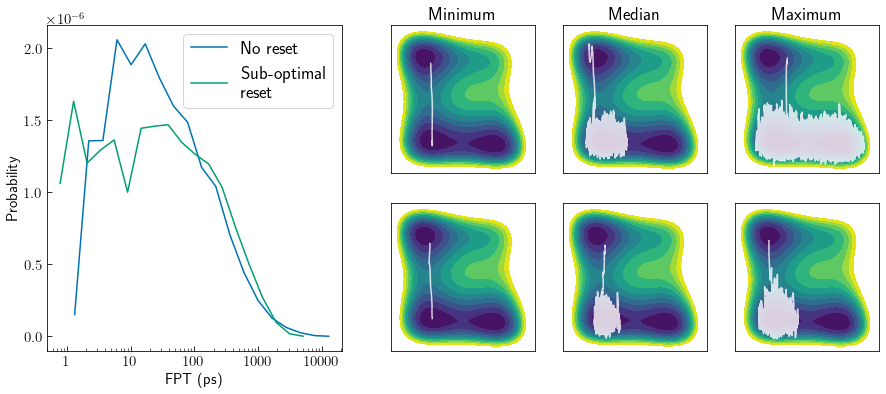

In [799]:
fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(2,6,3)
ax2 = plt.subplot(2,6,4)
ax3 = plt.subplot(2,6,5)
ax4 = plt.subplot(2,6,9)
ax5 = plt.subplot(2,6,10)
ax6 = plt.subplot(2,6,11)
ax7 = plt.subplot(1,3,1)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

pointsx = np.linspace(-35,35,100)
pointsy = np.linspace(-2.5,2.5,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,15,11)
for xt in pointsx:
    x = xt/15
    for yt in pointsy:
        y = yt/1
        Vs.append(1.5*0.59616*(x**4+y**4-2*x**2-4*y**2+x*y+1.5*x+1.2*y))
        xs.append(xt)
        ys.append(yt)
surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
for rate in [0,2]:
    FPTs = np.loadtxt(f"results/FPTWQrate{rate}",skiprows=1)

    logbins = np.logspace(np.log10(FPTs.min()),np.log10(FPTs.max()),20)
    xs = 0.5*(logbins[1:] + logbins[:-1])
    c,b = np.histogram(FPTs, bins=logbins, density=True)
    axs[-1].plot(xs/1e3,c)
    axs[-1].set_xscale("log")
    axs[-1].set_ylabel("Probability")
    axs[-1].set_xlabel("FPT (ps)")
    axs[-1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[-1].set_xticks([1,10,100,1000,10000])
axs[-1].legend(["No reset","Sub-optimal\n reset"])
for ax in axs[:-1]:
    ax.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
    ax.set_xticks([])
    ax.set_yticks([])
    # for x in (FPTs.min(),np.median(FPTs),FPTs.max()):
    #     axs[0].plot([x/1e3,x/1e3],[c.min(),c.max()])
subplot = 0
for seed in [11195,11455,12957,26383,23311,29107]:
    with open(f"../LAMMPS/trajectories/dump{seed}.xyz","r") as file:
        lines = file.readlines()
    xs = []
    ys = []
    for i in range(2,len(lines),3):
        xs.append(float(lines[i].split()[1]))
        ys.append(float(lines[i].split()[2]))
    axs[subplot].plot(xs,ys,c="white",alpha=0.8)
    subplot += 1
axs[0].set_title("Minimum")
axs[1].set_title("Median")
axs[2].set_title("Maximum")

In [185]:
datalist = []
for passage in [2,3,4]:
    fpts = pd.read_csv(f"results/FPT1Dpass{passage}",skiprows=1,names=["fpt"])
    rs = np.linspace(1e-6,0.0001,1000)
    Trs = np.array([sum(np.exp(-r*fpts.fpt))/len(fpts) for r in rs])
    mus = (1-Trs)/(rs*Trs)
    mus[0] = fpts.fpt.mean()
    times = np.arange(fpts.fpt.min(),fpts.fpt.max(),1000)
    probabilities = []
    mus2 = []
    for time in times:
        probabilities.append(len(fpts.loc[fpts.fpt<=time])/len(fpts))
    Pr = pd.DataFrame({"time":times,"P":probabilities,"P_":1-np.array(probabilities)})
    for r in rs:
        mus2.append(np.trapz(inter.loc[inter.time<=1/r].P_,inter.loc[inter.time<=1/r].time)/float(Pr.loc[Pr.time==int(0.001/r)*1000].P))
    datalist.append(pd.DataFrame({"Model":"1D","Passage":[-passage],"Mean":round(fpts.fpt.mean()/25000)*25,
                                  "COV":format(fpts.fpt.std()/fpts.fpt.mean(),'.2f'),"Predicted speedup (Poisson)":format(fpts.fpt.mean()/mus.min(),'.1f'),
                                 "Predicted speedup (Sharp)":format(fpts.fpt.mean()/min(mus2),'.1f')}))
data = pd.concat(datalist)
data = data.set_index("Model",drop=True)
print(data.to_latex())

\begin{tabular}{lrrlll}
\toprule
{} &  Passage &  Mean &   COV & Predicted speedup (Poisson) & Predicted speedup (Sharp) \\
Model &          &       &       &                             &                           \\
\midrule
1D    &       -2 &  1200 &  3.09 &                        11.3 &                      14.8 \\
1D    &       -3 &  1325 &  2.92 &                         9.7 &                      12.6 \\
1D    &       -4 &  1500 &  2.80 &                         8.6 &                      11.4 \\
\bottomrule
\end{tabular}



In [116]:
fpts = pd.read_csv(f"results/FPT1Dpass{3}",skiprows=1,names=["fpt"])
times = np.arange(fpts.fpt.min(),fpts.fpt.max(),1000)
probabilities = []
for time in times:
    probabilities.append(len(fpts.loc[fpts.fpt<=time])/len(fpts))
Pr = pd.DataFrame({"time":times,"P":probabilities,"P_":1-np.array(probabilities)})

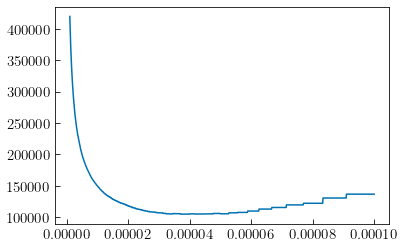

In [178]:
mus = []
rs = np.linspace(1e-6,0.0001,1000)
for r in rs:
    mus.append(np.trapz(inter.loc[inter.time<=1/r].P_,inter.loc[inter.time<=1/r].time)/float(Pr.loc[Pr.time==int(0.001/r)*1000].P))


In [177]:
Pr

,time,P,P_
0,2000,0.0004,0.9996
1,3000,0.0009,0.9991
2,4000,0.0037,0.9963
3,5000,0.0086,0.9914
4,6000,0.0147,0.9853
...,...,...,...
49993,49995000,0.9994,0.0006
49994,49996000,0.9994,0.0006
49995,49997000,0.9994,0.0006
49996,49998000,0.9994,0.0006


(1.9639338104477257, 15879000.0)

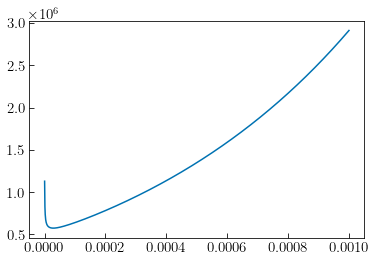

In [632]:
rs = np.linspace(0,1e-3,2000)
fpts = np.loadtxt("results/FPTWQrate0",skiprows=1)
# fpts = np.loadtxt("results/FPT2Grate0",skiprows=1)
# fpts = np.loadtxt("results/FPT1Drate0",skiprows=1)
Trs = np.array([sum(np.exp(-r*fpts))/len(fpts) for r in rs])
mus = (1-Trs)/(rs*Trs)
mus[0] = fpts.mean()
plt.plot(rs,mus)
# plt.plot(1/rs,mus)
# plt.plot([5000,10000,20000,40000,80000,160000,320000,640000],[500000 for i in range(8)],"o")
# plt.xscale("log")
mus[0]/mus.min(), fpts.max()

In [10]:
dat = pd.DataFrame({"t":np.linspace(0,9999,10000),"fpt":fpts})
dat.loc[dat.fpt==50000000]

,t,fpt
891,891.0,50000000.0
940,940.0,50000000.0
5049,5049.0,50000000.0
7722,7722.0,50000000.0
9286,9286.0,50000000.0
9465,9465.0,50000000.0


,x,y,V
3123,-1.494949,-2.141414,0.0


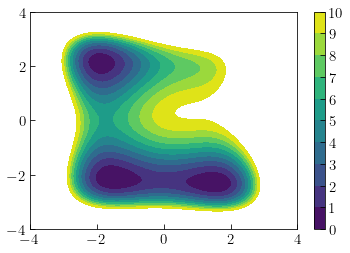

In [458]:
pointsx = np.linspace(-4,4,100)
pointsy = np.linspace(-4,4,100)
xs = []
ys = []
Vs = []
levels = np.linspace(0,10,11)
for xt in pointsx:
    x = xt/1.5
    for yt in pointsy:
        y = yt/1.5
        Vs.append(1.4*0.59616*(1*x**4+y**4-2*x**2-4*y**2+1.*x*y+1.5*x+1.2*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
surface.V = surface.V/0.59616
plt.tricontourf(surface.x,surface.y,surface.V,levels=levels)
cbar = plt.colorbar(ticks=levels)
V = surface.loc[surface.y<0]
V.loc[V.V==V.V.min()]

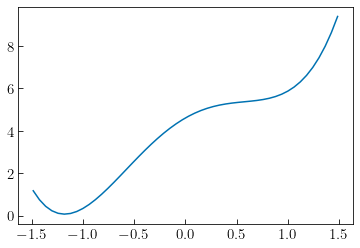

In [143]:
V = surface.loc[surface.y>-2].loc[surface.y<2].loc[surface.x>-1.1].loc[surface.x<-1]
# plt.plot(V.y,V.V)
V = surface.loc[surface.y<1.6].loc[surface.y>1.5].loc[surface.x>-1.5].loc[surface.x<1.5]
plt.plot(V.x,V.V)

# surface.loc[surface.V==0]

,x,y,V
7221,1.30303,0.0,1.776357e-15


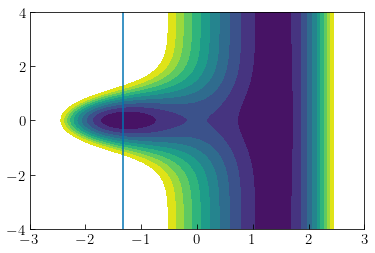

In [482]:
pointsy = np.linspace(-4,4,101)
pointsx = np.linspace(-3,3,100)
xs = []
ys = []
Vs = []
A = [24.44, 24.44]
alphas = [1.3,1.3]
lambdas = [2000,1]
x0s = [2.5,-2.5]
y0s = [0,0]

levels = np.linspace(0,15,11)
for x in pointsx:
    for y in pointsy:
        W_1 = A[0]*np.exp(-(x-x0s[0])**2/(2*alphas[0]**2)-(y-y0s[0])**2/(2*lambdas[0]**2))
        W_2 = A[1]*np.exp(-(x-x0s[1])**2/(2*alphas[1]**2)-(y-y0s[1])**2/(2*lambdas[1]**2))
        Vs.append((-(W_1 + W_2) + 4*x**2 + 0.0005*y**2))
        xs.append(x)
        ys.append(y)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
fig, ax = plt.subplots()
# axins = ax.inset_axes([0.08, 0.6, 0.3, 0.3])
ax.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
# axins.tricontourf(surface.x,surface.y,surface.V/0.59616,levels=levels)
# axins.set_xlim(-2.5, 2)
# axins.set_ylim(-5, 5)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.xaxis.set_ticks_position('none') 
# axins.yaxis.set_ticks_position('none') 
# ax.indicate_inset_zoom(axins, edgecolor="black")
ax.plot([-4/3,-4/3],[-4,4])
# lim = -1
right = surface.loc[surface.x>0]
right.loc[right.V==right.V.min()]
# plt.plot([lim,lim],[-5,5],linestyle="dashed",c="white")

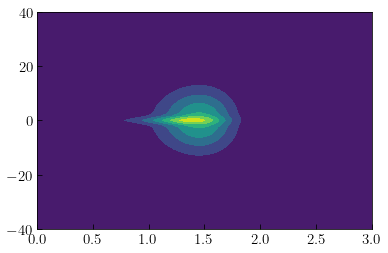

In [135]:
pointsy = np.linspace(-40,40,101)
pointsx = np.linspace(0,3,100)
xs = []
ys = []
Vs = []
A = [26,26]
alphas = [1.3,1.3]
lambdas = [200,1]
x0s = [2.5,-2.5]
y0s = [0,0]

levels = np.linspace(0,15,11)
for x in pointsx:
    for y in pointsy:
        W_1 = A[0]*np.exp(-(x-x0s[0])**2/(2*alphas[0]**2)-(y-y0s[0])**2/(2*lambdas[0]**2))
        W_2 = A[1]*np.exp(-(x-x0s[1])**2/(2*alphas[1]**2)-(y-y0s[1])**2/(2*lambdas[1]**2))
        Vs.append((-(W_1 + W_2) + 4*x**2 + 0.005*y**2))
        xs.append(x)
        ys.append(y)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min() 
surface["H"] = np.exp(-surface.V/0.59616)
fig, ax = plt.subplots()
ax.tricontourf(surface.x,surface.y,surface.H)

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([-2.5 , -2.45, -2.4 , -2.35, -2.3 , -2.25, -2.2 , -2.15, -2.1 ,
        -2.05, -2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65,
        -1.6 , -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 ,
        -1.15, -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75,
        -0.7 , -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 ,
        -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,
         0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,
         1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,
         1.55,  1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,
         2.  ,  2.05,  2.1 ,  2.15,  2.2 

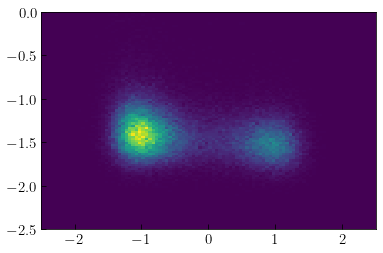

In [151]:
params = dict(resetRate=0.0,
              mass=40,
              height=0.59616*1.5,
              Cx = 2.,
              Cx4 = 1,
              xscale=1.,
              yscale=1.,
              xslope=1.75,
              yslope=1.25,
              startx=-4,
              starty=-1.4,
              passageCoordinate="y",
              passageValue=1,
              passageSign=">",
              round=1000,
              seed=10000)
pointsy = np.linspace(0,-2.5,100)
pointsx = np.linspace(-2.5,2.5,100)

xs = []
ys = []
Vs = []
for xt in pointsx:
    x = xt/params["xscale"]
    for yt in pointsy:
        y = yt/params["yscale"]
        Vs.append(params["height"]*(params["Cx4"]*x**4+y**4-params["Cx"]*x**2-4*y**2+x*y+params["xslope"]*x+params["yslope"]*y))
        xs.append(xt)
        ys.append(yt)

surface = pd.DataFrame({"x":xs,"y":ys,"V":Vs})
surface.V -= surface.V.min()
surface["H"] = np.exp(-surface.V/0.59616)
flat = surface.H
flat = flat/sum(flat)
for i in range(100000):
    sample_index = np.random.choice(a=flat.size, p=flat)
    xs.append(surface.x[sample_index])
    ys.append(surface.y[sample_index])
plt.hist2d(xs, ys, bins=100)

In [600]:
rate = 1e-7

Tr = IGLaplace(rate,mu,D,1)
mus = (1-Tr)/(rate*Tr)
(1-Tr)/rate, mus


# plot simulated
# mus = []
# pres = []
# for rate in rs:
#     samples = np.array([sample(invgauss.rvs,dict(mu=m,scale=s),rate) for i in range(50000)])
#     mus.append(samples.mean())
#     selrs = np.linspace(rate,rate+8*rate/dr,9)
#     selTrs = np.array([sum(np.exp(-r*samples))/len(samples) for r in (selrs-rate)])
#     selmus = (1-selTrs)/((selrs-rate)*selTrs)
#     selmus[0] = samples.mean()
#     pres.append(forwardExpansion(0,rate,rate/dr,selmus))

# mus = np.array(mus)
# pres = np.array(pres)
# ax.scatter(0.001*oneOverRs,mus/1000)
# ax.scatter(0.001*oneOverRs,pres/1000)

(563307.9219881399, 596933.6684204054)